   customer_id  acquisition_time  churn_time  churned  time_to_churn  \
0            0                 0       121.0        1          121.0   
1            1                 0        31.0        1           31.0   
2            2                 0        14.0        1           14.0   
3            3                 0         5.0        1            5.0   
4            4                 0         1.0        1            1.0   

  usage_frequency plan_type  age start_date   end_date age_group  
0            high     basic   53 2023-01-01 2023-05-02     41-60  
1            high     basic   19 2023-01-01 2023-02-01      0-25  
2          medium     basic   38 2023-01-01 2023-01-15     26-40  
3             low     basic   39 2023-01-01 2023-01-06     26-40  
4             low     basic   66 2023-01-01 2023-01-02       60+  


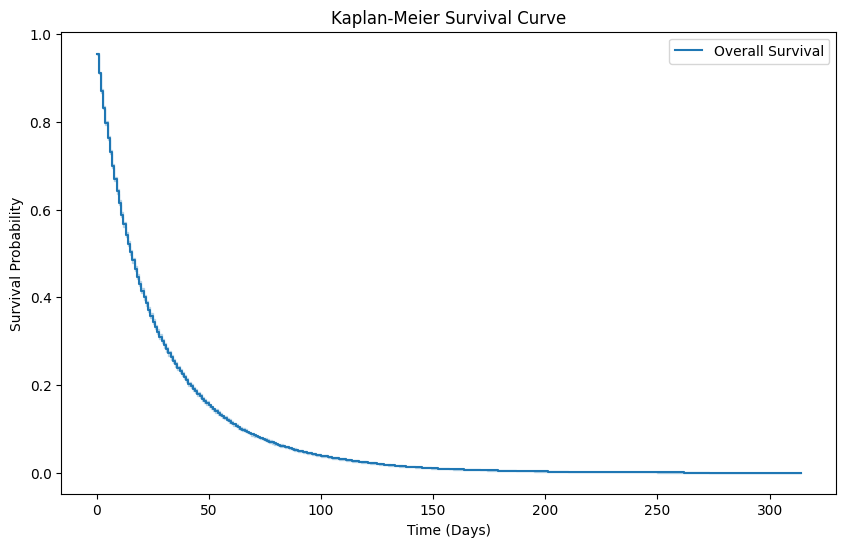

Median Survival Time: 16.0


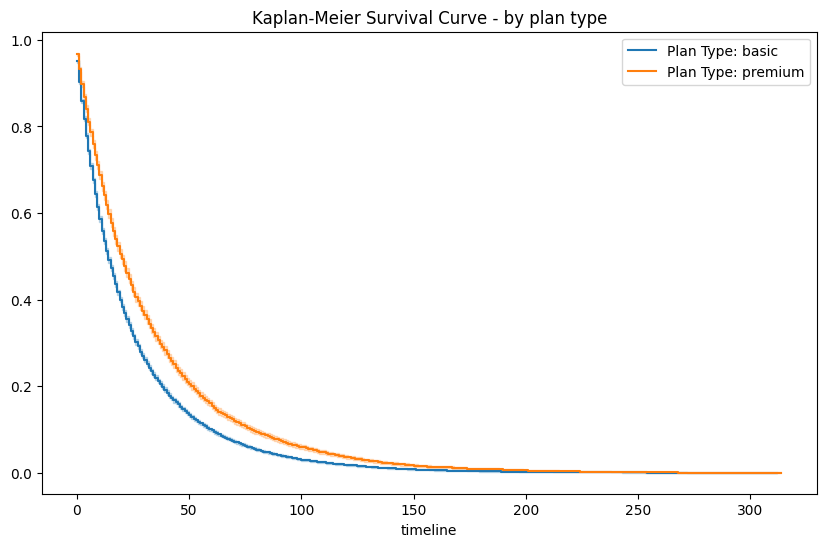

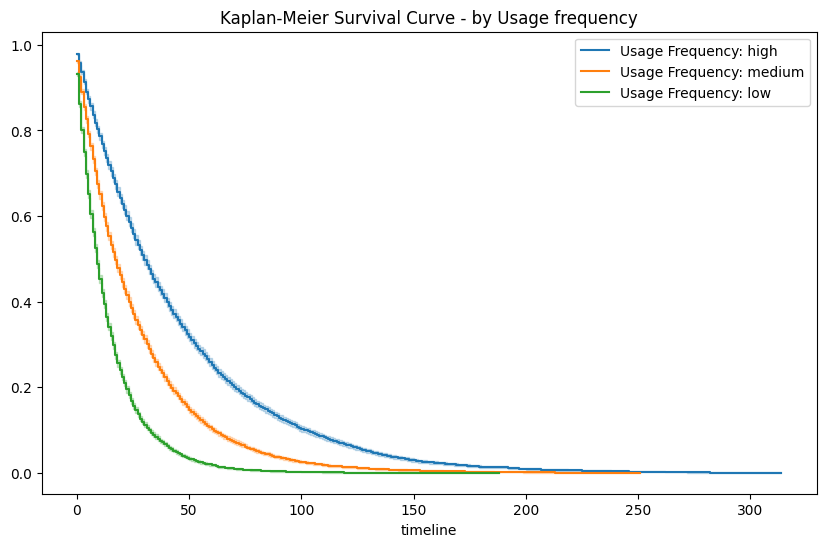

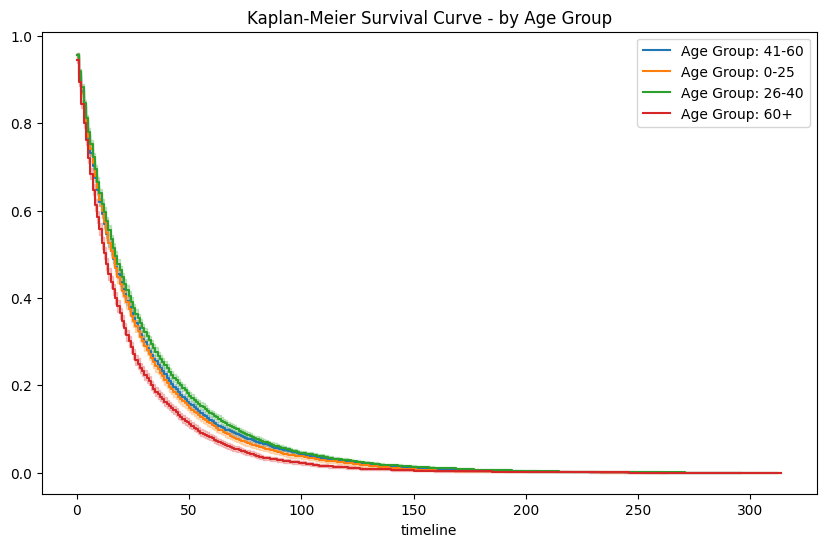

<lifelines.CoxPHFitter: fitted with 29365 total observations, 0 right-censored observations>
             duration col = 'time_to_churn'
                event col = 'churned'
      baseline estimation = breslow
   number of observations = 29365
number of events observed = 29365
   partial log-likelihood = -269692.89
         time fit was run = 2025-02-26 13:43:23 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
usage_frequency_low     1.16      3.18      0.02            1.13            1.19                3.09                3.28
usage_frequency_medium  0.52      1.69      0.02            0.50            0.55                1.64                1.74
plan_type_premium      -0.33      0.72      0.01           -0.36           -0.31                0.70                0.74
age_group_26-40        -0.11      0.90      0.02           -0.14           -0.07                0.87                0.93
age_group_41-60        -0.03      0.97      0.02           -0.07            0.00                0.94                1.00
age_group_60+           0.21      1.23      0.02            0.17            0.25                1.18                1.28

                        cmp to      z      p  -log2(p)
covariate                                             
usage_frequency_low       0.00  73.31 <0.005       inf
usage_frequency_medium    0.00  34.61 <0.005    869.43
plan_type_premium         0.00 -25.55 <0.005    476.02
age_group_26-40           0.00  -5.74 <0.005     26.70
age_group_41-60           0.00  -1.81   0.07      3.83
age_group_60+             0.00  10.10 <0.005     77.33
---
Concordance = 0.64
Partial AIC = 539397.78
log-likelihood ratio test = 6084.67 on 6 df
-log2(p) of ll-ratio test = inf

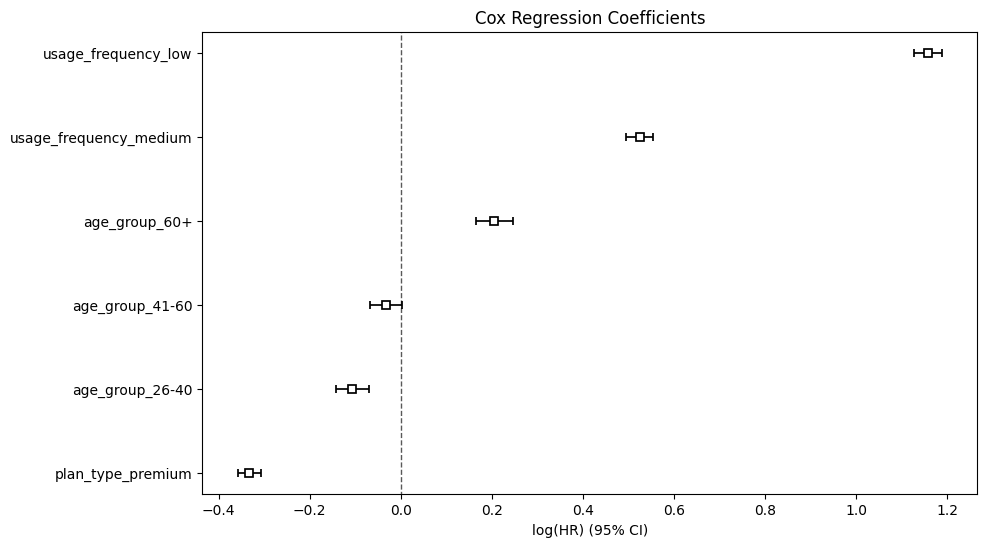

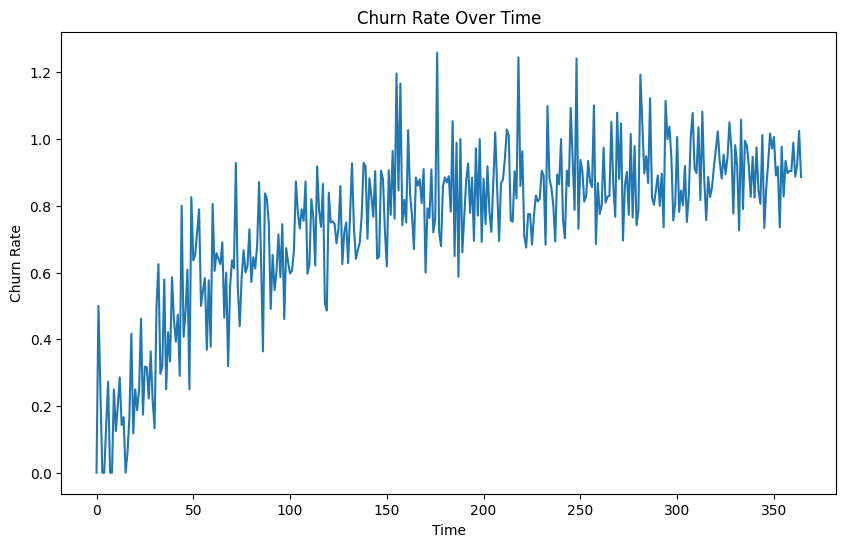

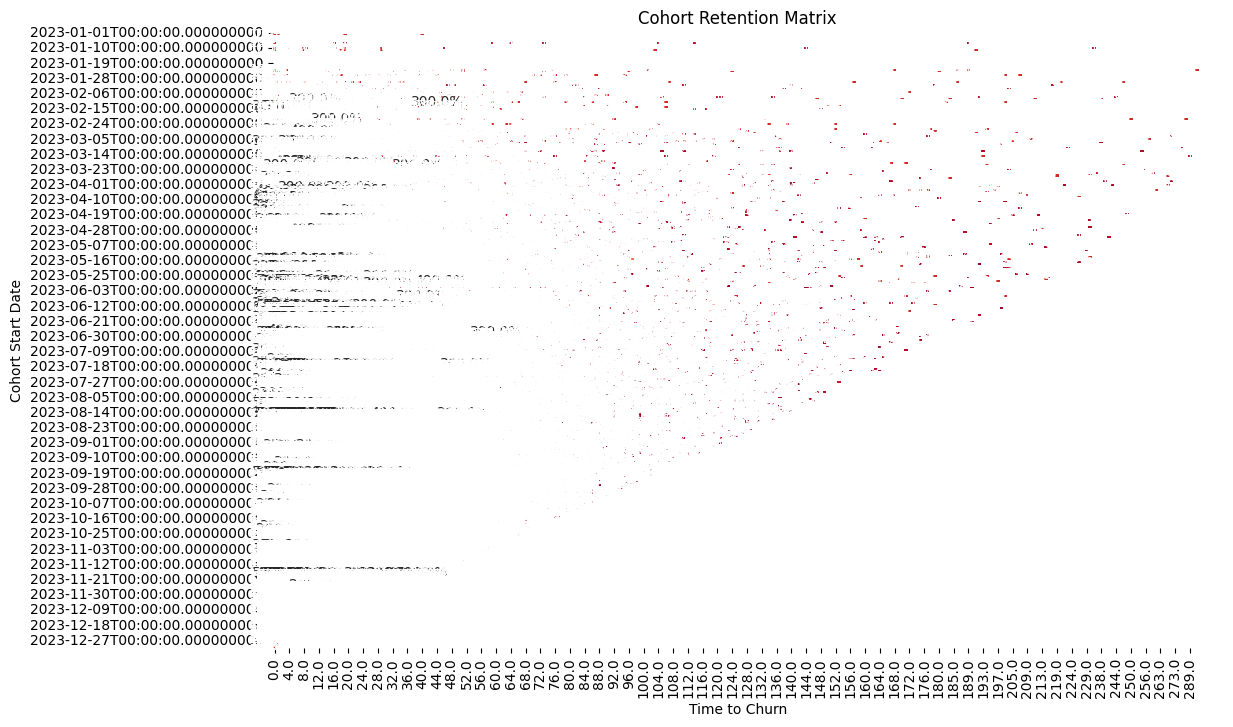


--- Simulation Complete ---


In [5]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import median_survival_times
import matplotlib.pyplot as plt
from scipy.stats import poisson
from datetime import datetime, timedelta
import random


def simulate_churn(
    n_customers: int,
    time_horizon: int,
    acquisition_rate_func,  # Function: time -> num_new_customers
    base_churn_rate: float,
    churn_rate_modifiers,  # List of dictionaries: {'condition': function, 'churn_factor': float}
    start_date: datetime,
    features: dict = None,  # Dictionary: {'feature_name': distribution_function}
    feature_churn_effects=None,  # List of dictionaries: {'feature': 'feature_name', 'value': value, 'churn_factor': float}
    random_seed=42,
    age_groups = None,
) -> pd.DataFrame:
    """
    Simulates customer churn over a specified time horizon.

    Args:
        n_customers: Initial number of customers at time 0.
        time_horizon: Number of time periods (e.g., days, months) to simulate.
        acquisition_rate_func:  A function that takes the current time step and returns the number of new customers acquired.
        base_churn_rate: The baseline probability of a customer churning in a given period.
        churn_rate_modifiers: A list of dictionaries. Each dictionary defines a condition
            and a multiplicative factor for the churn rate if the condition is met.  Conditions are functions that take a customer row as input.
        start_date:  The starting datetime for the simulation.
        features: (Optional) A dictionary where keys are feature names and values are functions to generate
            random values for those features for each customer (e.g., using scipy.stats distributions).
        feature_churn_effects: (Optional) List of dictionaries. Each dict specifies how a feature's value
            affects the churn rate.  Format:  {'feature': 'feature_name', 'value': feature_value, 'churn_factor': float}
        random_seed: Seed for reproducibility
        age_groups: (Optional): pre-calculated age_groups to avoid recalculating it inside the loop.

    Returns:
        A Pandas DataFrame where each row represents a customer's history.
        Columns include:
            - customer_id: Unique identifier for the customer.
            - acquisition_time: Time step when the customer was acquired.
            - churn_time: Time step when the customer churned (NaN if they didn't churn).
            - churned: Boolean indicating whether the customer churned (1) or not (0).
            - time_to_churn:  Number of time steps until churn (NaN if didn't churn).
            - [feature_name]: (Optional) Columns for any additional features provided.
            - start_date: Date customer was acquired
            - end_date: Date of churn or end of simulation (if customer did not churn)
    """

    random.seed(random_seed)
    np.random.seed(random_seed)

    customers = []
    customer_id_counter = 0

    for time in range(time_horizon):
        # 1. Customer Acquisition
        n_new_customers = acquisition_rate_func(time)
        for _ in range(n_new_customers):
            customer = {"customer_id": customer_id_counter, "acquisition_time": time, "churn_time": np.nan, "churned": 0, "time_to_churn":np.nan}

            # Generate feature values
            if features:
                for feature_name, distribution_func in features.items():
                    customer[feature_name] = distribution_func()

            customers.append(customer)
            customer_id_counter += 1


        # 2. Churn Simulation
        for i in range(len(customers)):
          customer = customers[i]
          if np.isnan(customer["churn_time"]):  # Only simulate churn for active customers
                current_churn_rate = base_churn_rate

                # Apply churn modifiers based on conditions
                for modifier in churn_rate_modifiers:
                    if modifier["condition"](customer):
                        current_churn_rate *= modifier["churn_factor"]

                # Apply feature-based churn effects
                if feature_churn_effects:
                  for effect in feature_churn_effects:
                    if customer.get(effect['feature']) == effect['value']:
                      current_churn_rate *= effect['churn_factor']

                # Ensure churn rate is a valid probability (0 <= rate <= 1)
                current_churn_rate = min(max(current_churn_rate, 0), 1)

                if random.random() < current_churn_rate:
                    customer["churn_time"] = time
                    customer["churned"] = 1
                    customer['time_to_churn'] = time - customer['acquisition_time']
                    customers[i] = customer


    df = pd.DataFrame(customers)
    # Calculate start and end dates.
    df['start_date'] = df['acquisition_time'].apply(lambda x: start_date + timedelta(days=x))
    df['end_date'] = df.apply(lambda row: start_date + timedelta(days=int(row['churn_time'])) if not np.isnan(row['churn_time']) else start_date + timedelta(days=time_horizon) , axis=1)

    # Add age_group here, *after* the DataFrame is created
    if 'age' in df.columns:  # Check if 'age' exists (in case features are not used)
        df['age_group'] = pd.cut(df['age'], bins=[0, 25, 40, 60, 100], labels=['0-25', '26-40', '41-60', '60+'])
    return df



def plot_km_curve(df: pd.DataFrame, duration_col: str, event_col: str, label:str = None):
    """Plots the Kaplan-Meier survival curve."""
    kmf = KaplanMeierFitter()
    # Handle NaNs by filtering the DataFrame
    df_filtered = df.dropna(subset=[duration_col, event_col])
    kmf.fit(df_filtered[duration_col], event_observed=df_filtered[event_col], label=label)
    kmf.plot_survival_function()
    return kmf

def perform_cox_regression(df: pd.DataFrame, duration_col: str, event_col: str, covariates: list):
    """Performs Cox Proportional Hazards regression and prints the summary."""
    cph = CoxPHFitter()
    cph.fit(df[[duration_col, event_col] + covariates], duration_col=duration_col, event_col=event_col)
    cph.print_summary()  # Print the results.
    return cph

def calculate_median_survival_time(kmf):
     return median_survival_times(kmf.survival_function_)


# --- Example Usage ---
if __name__ == "__main__":
    # 1. Define Simulation Parameters

    def linear_acquisition(time):
        return 10 + time * 2  # Start with 10 customers, add 2 more each period

    def poisson_acquisition(time):
        # Example: Average acquisition rate increases over time
        rate = 5 + time * 0.5
        return poisson.rvs(rate)


    churn_modifiers = [
        {"condition": lambda customer: customer["acquisition_time"] < 30, "churn_factor": 0.7},  # New customers are less likely to churn
        {"condition": lambda customer: customer["acquisition_time"] > 100, "churn_factor": 1.2}, #older users more likely to churn
    ]

    start_date = datetime(2023, 1, 1)

    # Feature definitions:
    features = {
      'usage_frequency': lambda: np.random.choice(['low', 'medium', 'high']),
      'plan_type': lambda: np.random.choice(['basic', 'premium'], p=[0.7, 0.3]),  # 70% basic, 30% premium
      'age': lambda: np.random.randint(18, 70)
    }

    feature_effects = [
      {'feature': 'usage_frequency', 'value': 'low', 'churn_factor': 2.0},
      {'feature': 'usage_frequency', 'value': 'high', 'churn_factor': 0.5},
      {'feature': 'plan_type', 'value': 'basic', 'churn_factor': 1.5},
      {'feature': 'age', 'value': 30, 'churn_factor': 0.9} # this effect is not applied directly, age range needs to be calculated (see below).
    ]



    age_churn_modifiers = [
      {"condition": lambda customer: 25 < customer["age"] <= 40, "churn_factor": 0.9}, # example. using conditions, not feature effect
      {"condition": lambda customer: customer["age"] > 60, "churn_factor": 1.3},
    ]

    # 2. Run the Simulation (First time, to get age groups if needed)
    churn_data = simulate_churn(
        n_customers=0,  # Start with 0, use acquisition function
        time_horizon=365,
        acquisition_rate_func=poisson_acquisition,
        base_churn_rate=0.02,
        churn_rate_modifiers=churn_modifiers,
        start_date=start_date,
        features=features,
        feature_churn_effects=feature_effects,
        random_seed = 42
    )

      # 2. Run the Simulation with modifiers.
    churn_data_modified = simulate_churn(
            n_customers=0,
            time_horizon=365,
            acquisition_rate_func=poisson_acquisition,
            base_churn_rate=0.02,
            churn_rate_modifiers=churn_modifiers + age_churn_modifiers,
            start_date=start_date,
            features=features,
            feature_churn_effects=feature_effects,
            random_seed=42,
        )
    print(churn_data_modified.head())



    # --- 3. Churn Analysis ---

    # 3.1 Kaplan-Meier Survival Curve
    plt.figure(figsize=(10, 6))
    kmf = plot_km_curve(churn_data_modified, "time_to_churn", "churned", label="Overall Survival")
    plt.title("Kaplan-Meier Survival Curve")
    plt.xlabel("Time (Days)")
    plt.ylabel("Survival Probability")
    plt.show()

    # Calculate and display median survival time.
    median_survival = calculate_median_survival_time(kmf)
    print(f"Median Survival Time: {median_survival}")

    #3.1.1. KM curve by segment.

    plt.figure(figsize=(10, 6))

    for segment in churn_data_modified['plan_type'].unique():
      subset = churn_data_modified[churn_data_modified['plan_type'] == segment]
      plot_km_curve(subset, 'time_to_churn', 'churned', label=f'Plan Type: {segment}')
    plt.title("Kaplan-Meier Survival Curve - by plan type")
    plt.show()


    plt.figure(figsize=(10, 6))
    for segment in churn_data_modified['usage_frequency'].unique():
      subset = churn_data_modified[churn_data_modified['usage_frequency'] == segment]
      plot_km_curve(subset, 'time_to_churn', 'churned', label=f'Usage Frequency: {segment}')
    plt.title("Kaplan-Meier Survival Curve - by Usage frequency")
    plt.show()


    plt.figure(figsize=(10, 6))
    for segment in churn_data_modified['age_group'].unique():
      subset = churn_data_modified[churn_data_modified['age_group'] == segment]
      plot_km_curve(subset, 'time_to_churn', 'churned', label=f'Age Group: {segment}')
    plt.title("Kaplan-Meier Survival Curve - by Age Group")
    plt.show()


    # 3.2 Cox Proportional Hazards Regression
    # Prepare data for Cox regression (need numerical/categorical data).
    cox_data = churn_data_modified.copy()
    cox_data = pd.get_dummies(cox_data, columns=['usage_frequency', 'plan_type', 'age_group'], drop_first=True)  # One-hot encode
    # Drop columns not needed and the ones that have NaN (customers that have not churned).
    cox_data = cox_data.dropna(subset=['time_to_churn'])
    cox_data = cox_data.drop(['customer_id', 'acquisition_time', 'churn_time', 'start_date', 'end_date', 'age'], axis=1, errors='ignore')

    covariates = [col for col in cox_data.columns if col not in ['churned', 'time_to_churn']]
    cph = perform_cox_regression(cox_data, 'time_to_churn', 'churned', covariates)

    # Plot the coefficients
    plt.figure(figsize=(10, 6))
    cph.plot()
    plt.title("Cox Regression Coefficients")
    plt.show()

    # 4.  Churn Rate over Time
    churn_rate_over_time = churn_data_modified.groupby('churn_time')['customer_id'].count() / churn_data_modified.groupby('acquisition_time')['customer_id'].count()
    #Handle possible division by zero
    churn_rate_over_time = churn_rate_over_time.fillna(0)


    plt.figure(figsize=(10,6))
    plt.plot(churn_rate_over_time)
    plt.xlabel("Time")
    plt.ylabel("Churn Rate")
    plt.title("Churn Rate Over Time")
    plt.show()


    #5. Cohort Analysis
    # Use start_date as the cohort
    cohorts = churn_data_modified.groupby(['start_date', 'time_to_churn'])['customer_id'].count().reset_index()
    cohorts = cohorts.pivot(index='start_date', columns='time_to_churn', values='customer_id')

    cohort_sizes = cohorts.iloc[:,0]
    retention_matrix = cohorts.divide(cohort_sizes, axis=0)

    # Plotting the retention matrix
    plt.figure(figsize=(12, 8))
    plt.title('Cohort Retention Matrix')
    import seaborn as sns
    sns.heatmap(retention_matrix, annot=True, fmt='.1%', cmap='RdYlGn', cbar=False)
    plt.ylabel('Cohort Start Date')
    plt.xlabel('Time to Churn')
    plt.show()

    print("\n--- Simulation Complete ---")